<a href="https://colab.research.google.com/github/VSAnimator/collage-diffusion/blob/main/CollageDiffusionDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions

To run Collage Diffusion, we need to specify a sequence of RGBA image layers as input--under "Set asset paths", point to the location in Google Drive where you have these assets stored. For improved performance, we would also like textual representations specialized to the individual collage layers--we have provided these assets for several test scenes from the paper, add these assets to your Google Drive and point "asset_folder" to the correct location.

After "Code Setup", we have illustrated an iterative image generation and editing pipeline for the three test scenes provided. There are inline comments describing the chosen parameters in each section. 

# Set asset paths

In [1]:
import os
scene_dir = "/ssd/xiedong/home/InST-main/collage-diffusion-main/image_layers/"
asset_folder = "/ssd/xiedong/home/InST-main/collage-diffusion-main/asset_library"

Mounted at /content/gdrive


# Code Setup

In [2]:
%pip install diffusers==0.10.0
%pip install accelerate
%pip install transformers
%pip install einops
%pip install pytorch-lightning
%pip install python-multipart==0.0.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.9/502.9 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 13.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 69.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━

In [4]:
import torch
from transformers import CLIPModel, CLIPTextModel, CLIPTokenizer
import numpy as np
import random
from PIL import Image, ImageFilter
from torch import autocast
from difflib import SequenceMatcher
import pickle
import math
from einops import rearrange, repeat
import matplotlib.pyplot as plt
import os

In [7]:
import torchvision.transforms as transforms

class ImageLayer:
    def __init__(self, rgba, pos, image_str, ftc = None):
        self.rgba = rgba
        self.pos = pos
        self.image_str = image_str
        self.ftc = ftc # Optional, used for textual inversion
    
    def get_mask(self):
        return (np.array(self.rgba)[:,:,3]/255)
    
    @staticmethod
    def get_mask(image):
        return (np.array(image)[:,:,3]/255)
    
    def get_bbox(self):
        img = self.get_mask() > 0.5
        rows = np.any(img, axis=1)
        cols = np.any(img, axis=0)
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]

        return rmin, cmin, rmax, cmax
    
    @staticmethod
    def get_bbox_from_mask(img):
        rows = np.any(img, axis=1)
        cols = np.any(img, axis=0)
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
        
        return rmin, cmin, rmax, cmax
    
    @staticmethod
    def get_box_mask(img):
        print(img.shape)
        init_mask = np.zeros(img.shape,dtype=float)
        bbox = ImageLayer.get_bbox_from_mask(img)
        init_mask[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1] = 1.
        return init_mask
    
    def get_init_mask(self, bbox=False):
        if bbox:
            init_mask = np.zeros(self.rgba.size,dtype=float)
            bbox = self.get_bbox()
            init_mask[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1] = 1.
        else:
            init_mask = self.get_mask()
        return init_mask

    @staticmethod   
    def get_pyramid(init_mask, res_list, device):
        # Now we have a float mask for all the regions we want to emphasize
        torch_mask = torch.tensor(init_mask).unsqueeze(0)
        return_dict = {}
        for res in res_list:
            temp_im = transforms.Resize(size=res)(torch_mask).to(device)
            return_dict[res] = temp_im
        return return_dict
    
    @staticmethod
    def bottom_visible(bottom, top):
        return (bottom*(1. - top))
    
    @staticmethod
    def blur_mask(img, blur_size):
        img = np.array(Image.fromarray((img*255).astype(np.uint8), 'L').filter(ImageFilter.GaussianBlur(blur_size)))/255.
        return img
    
    @staticmethod
    def add_layers(layer_list):
        """
        Returns: 
          (1) composite image (PIL.Image)
          (2) a mask per layer
        """

        composite_image = Image.new("RGB", (512,512), (150,150,150))
        num_layers = len(layer_list)
        for i in range(0, num_layers):
            composite_image.paste(layer_list[i].rgba, layer_list[i].pos, layer_list[i].rgba)
        ftb_composites = []
        for i in range(1, num_layers):
            new_composite = Image.new("RGBA", (512,512), (150,150,150,0))
            for j in range(i, num_layers):
                new_composite.paste(layer_list[j].rgba, layer_list[j].pos, layer_list[j].rgba)
            ftb_composites.append(new_composite)
        ftb_composites.append(Image.new("RGBA", (512,512), (150,150,150,0)))
        mask_layers = []
        for i in range(0, num_layers):
            bottom_mask = Image.new("RGBA", (512,512), (150,150,150,0))
            bottom_mask.paste(layer_list[i].rgba, layer_list[i].pos, layer_list[i].rgba)
            bottom_mask = ImageLayer.get_mask(bottom_mask)
            top_mask = ImageLayer.get_mask(ftb_composites[i])
            mask_layers.append(ImageLayer.bottom_visible(bottom_mask, top_mask))

        return composite_image, mask_layers

In [8]:
class FineTuneConcept:
    def __init__(self, image_name, image, instance_prompt, init_token):
        self.image_name = image_name
        self.image = image
        self.instance_prompt = instance_prompt
        self.init_token = init_token

    def build_ti_script(self):
        # Concat model name
        model_string = 'export MODEL_NAME="stabilityai/stable-diffusion-2-1-base"\n'
        input_dir = asset_folder + '/' + self.image_name + '/'
        os.makedirs(input_dir, exist_ok=True)
        self.image.save(input_dir + "image.jpg")
        input_string = 'export INSTANCE_DIR="' + input_dir + '"\n'
        output_dir = asset_folder + '/' + self.image_name + '/'
        output_string = 'export OUTPUT_DIR="' + output_dir + '"\n'
        prompt_string = 'export INSTANCE_PROMPT="\'' + self.instance_prompt + '\'"\n'
        init_string = 'export INIT_TOKEN="\'' + self.init_token + '\'"\n'
        cmd_string = Path('../lorpt_template.txt').read_text()
        ti_script = model_string + input_string + output_string + prompt_string + init_string + cmd_string
        ti_script = ti_script.replace("$INSTANCE_PROMPT", "\"" + self.instance_prompt + "\"")
        ti_script = ti_script.replace("$INIT_TOKEN", "\"" + self.init_token + "\"")
        bash_dir = asset_folder + '/'
        os.makedirs(bash_dir, exist_ok=True)
        with open(bash_dir + self.image_name + '.sh', "w") as text_file:
            text_file.write(ti_script)
    
    def run_ti_script(self, device_id):
        bash_script = asset_folder + '/' + self.image_name + '.sh'
        subprocess.Popen("CUDA_VISIBLE_DEVICES=" + str(device_id) + " bash " + bash_script, shell=True,
             stdin=None, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT, close_fds=True, start_new_session=True)
        
    def test_ti(self, device_id):
        ckpt_path = asset_folder + '/' + self.image_name # Flat image directory 
        run_ti(self.instance_prompt, ckpt_path, "cuda:" + str(device_id))
        
    def get_ckpt_path(self, step):
        output_dir = asset_folder + '/' + self.image_name + '/'
        ckpt_path = output_dir + 'lora_weight_e' + str(step - 1) + '_s' + str(step) + '.ti.pt'
        return ckpt_path
    
    def training_complete(self, step):
        path = self.get_ckpt_path(step)
        return os.path.isfile(path)
    
    def all_ti(self, device_id):
        self.build_ti_script()
        self.run_ti_script(device_id)
        self.test_ti(device_id)

In [9]:
def init_attention_func_nvda(unet, tokens, masks, strengths, neg_strengths, sigma, orig_sched=False):
    def new_attention(self, query, key, value):
        if self.upcast_attention:
            query = query.float()
            key = key.float()

        attention_scores = torch.baddbmm(
            torch.empty(query.shape[0], query.shape[1], key.shape[1], dtype=query.dtype, device=query.device),
            query,
            key.transpose(-1, -2),
            beta=0,
            alpha=self.scale,
        )
        
        ##############################################
        attention_probs = attention_scores
        b = 2
        bh, n, d = attention_probs.shape
        h = bh // b
        num_iter = bh//(h*2)
        attention_probs = rearrange(attention_probs,'(b h) n d -> b h n d', b=b)
        n1 = (int)(np.sqrt(n))
        attention_probs = rearrange(attention_probs,'b h (n1 n2) d -> b h n1 n2 d', n1 = n1)
        
        for i in range(num_iter):
            for j in range(len(tokens)):
                mask = masks[j][n1] # Mask pyramid is a dict so we can do this. Shape: (1,n1,n1)
                if orig_sched:
                    max_val = attention_probs[num_iter+i,:,:,:,tokens[j]].max()
                    attention_probs[num_iter+i,:,:,:,tokens[j]] += mask*strengths[j]*math.log(sigma + 1.01)*max_val
                    attention_probs[num_iter+i,:,:,:,tokens[j]] -= (1. - mask)*neg_strengths[j]*math.log(sigma + 1.01)*max_val
                else:
                    max_val = attention_probs[num_iter+i,:,:,:,tokens[j]].max()
                    attention_probs[num_iter+i,:,:,:,tokens[j]] += mask*strengths[j]*math.log(math.log(sigma + 1.01) + 1.)*max_val
                    attention_probs[num_iter+i,:,:,:,tokens[j]] -= (1. - mask)*neg_strengths[j]*math.log(math.log(sigma + 1.01) + 1.)*max_val
        attention_probs = rearrange(attention_probs,'b h n1 n2 d -> b h (n1 n2) d')
        attention_probs = rearrange(attention_probs,'b h n d -> (b h) n d', b=b)
        attention_scores = attention_probs
        #################################################
        
        
        attention_probs = attention_scores.softmax(dim=-1)

        # cast back to the original dtype
        attention_probs = attention_probs.to(value.dtype)

        # compute attention output
        hidden_states = torch.bmm(attention_probs, value)

        # reshape hidden_states
        hidden_states = self.reshape_batch_dim_to_heads(hidden_states)
        return hidden_states
    
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "CrossAttention" and "attn2" in name:
            module.last_attn_slice = None
            module.use_last_attn_slice = False
            module.use_last_attn_weights = False
            module.save_last_attn_slice = False
            module._attention = new_attention.__get__(module, type(module))

In [18]:
# Copyright 2022 The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import inspect
import copy
import math
from typing import Callable, List, Optional, Union, Dict
from PIL import Image, ImageFilter
from urllib.request import urlopen
from io import BytesIO
import numpy as np
from einops import rearrange, repeat
import io
import requests
import base64

import PIL
import torch

from diffusers.utils import is_accelerate_available
from packaging import version
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
from pytorch_lightning import seed_everything

from diffusers.configuration_utils import FrozenDict
from diffusers.models import AutoencoderKL, UNet2DConditionModel
from diffusers.pipeline_utils import DiffusionPipeline
from diffusers.schedulers import (
    DDIMScheduler,
    DPMSolverMultistepScheduler,
    EulerAncestralDiscreteScheduler,
    EulerDiscreteScheduler,
    LMSDiscreteScheduler,
    PNDMScheduler,
)
from diffusers.utils import PIL_INTERPOLATION, deprecate, logging
from diffusers.utils import deprecate, logging
from diffusers.pipelines.stable_diffusion import (
    StableDiffusionPipelineOutput,
    StableDiffusionSafetyChecker,
)


logger = logging.get_logger(__name__)  # pylint: disable=invalid-name


def preprocess_image(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=PIL_INTERPOLATION["lanczos"])
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.0 * image - 1.0


def preprocess_mask(mask, scale_factor=8):
    mask = mask.convert("L")
    w, h = mask.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    mask = mask.resize(
        (w // scale_factor, h // scale_factor), resample=PIL_INTERPOLATION["nearest"]
    )
    mask = np.array(mask).astype(np.float32) / 255.0
    mask = np.tile(mask, (4, 1, 1))
    mask = mask[None].transpose(0, 1, 2, 3)
    mask = 1 - mask  # repaint white, keep black
    mask = torch.from_numpy(mask)
    return mask


def load_learned_embed_in_clip(
    learned_embeds_path, text_encoder, tokenizer, new_token=None, idempotent=False
):
    loaded_learned_embeds = torch.load(learned_embeds_path, map_location="cpu")

    # separate token and the embeds
    token_list = list(loaded_learned_embeds.keys())
    for trained_token in token_list:
        embeds = loaded_learned_embeds[trained_token]

        # cast to dtype of text_encoder
        dtype = text_encoder.get_input_embeddings().weight.dtype

        # add the token in tokenizer
        token = new_token if new_token is not None else trained_token
        num_added_tokens = tokenizer.add_tokens(token)
        i = 1
        if num_added_tokens == 0 and idempotent:
            return token

        while num_added_tokens == 0:
            token = f"{token[:-1]}-{i}>"
            num_added_tokens = tokenizer.add_tokens(token)
            i += 1

        # resize the token embeddings
        text_encoder.resize_token_embeddings(len(tokenizer))

        # get the id for the token and assign the embeds
        token_id = tokenizer.convert_tokens_to_ids(token)
        text_encoder.get_input_embeddings().weight.data[token_id] = embeds
        print(token)
    return


class StableDiffusionPipeline(DiffusionPipeline):
    r"""
    Pipeline for text-to-image generation using Stable Diffusion.
    This model inherits from [`DiffusionPipeline`]. Check the superclass documentation for the generic methods the
    library implements for all the pipelines (such as downloading or saving, running on a particular device, etc.)
    Args:
        vae ([`AutoencoderKL`]):
            Variational Auto-Encoder (VAE) Model to encode and decode images to and from latent representations.
        text_encoder ([`CLIPTextModel`]):
            Frozen text-encoder. Stable Diffusion uses the text portion of
            [CLIP](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel), specifically
            the [clip-vit-large-patch14](https://huggingface.co/openai/clip-vit-large-patch14) variant.
        tokenizer (`CLIPTokenizer`):
            Tokenizer of class
            [CLIPTokenizer](https://huggingface.co/docs/transformers/v4.21.0/en/model_doc/clip#transformers.CLIPTokenizer).
        unet ([`UNet2DConditionModel`]): Conditional U-Net architecture to denoise the encoded image latents.
        scheduler ([`SchedulerMixin`]):
            A scheduler to be used in combination with `unet` to denoise the encoded image latents. Can be one of
            [`DDIMScheduler`], [`LMSDiscreteScheduler`], or [`PNDMScheduler`].
        safety_checker ([`StableDiffusionSafetyChecker`]):
            Classification module that estimates whether generated images could be considered offensive or harmful.
            Please, refer to the [model card](https://huggingface.co/runwayml/stable-diffusion-v1-5) for details.
        feature_extractor ([`CLIPFeatureExtractor`]):
            Model that extracts features from generated images to be used as inputs for the `safety_checker`.
    """
    _optional_components = ["safety_checker", "feature_extractor"]

    def __init__(
        self,
        vae: AutoencoderKL,
        text_encoder: CLIPTextModel,
        tokenizer: CLIPTokenizer,
        unet: UNet2DConditionModel,
        scheduler: Union[
            DDIMScheduler,
            PNDMScheduler,
            LMSDiscreteScheduler,
            EulerDiscreteScheduler,
            EulerAncestralDiscreteScheduler,
            DPMSolverMultistepScheduler,
        ],
        safety_checker: StableDiffusionSafetyChecker,
        feature_extractor: CLIPFeatureExtractor,
        requires_safety_checker: bool = True,
    ):
        super().__init__()

        if (
            hasattr(scheduler.config, "steps_offset")
            and scheduler.config.steps_offset != 1
        ):
            deprecation_message = (
                f"The configuration file of this scheduler: {scheduler} is outdated. `steps_offset`"
                f" should be set to 1 instead of {scheduler.config.steps_offset}. Please make sure "
                "to update the config accordingly as leaving `steps_offset` might led to incorrect results"
                " in future versions. If you have downloaded this checkpoint from the Hugging Face Hub,"
                " it would be very nice if you could open a Pull request for the `scheduler/scheduler_config.json`"
                " file"
            )
            deprecate(
                "steps_offset!=1", "1.0.0", deprecation_message, standard_warn=False
            )
            new_config = dict(scheduler.config)
            new_config["steps_offset"] = 1
            scheduler._internal_dict = FrozenDict(new_config)

        if (
            hasattr(scheduler.config, "clip_sample")
            and scheduler.config.clip_sample is True
        ):
            deprecation_message = (
                f"The configuration file of this scheduler: {scheduler} has not set the configuration `clip_sample`."
                " `clip_sample` should be set to False in the configuration file. Please make sure to update the"
                " config accordingly as not setting `clip_sample` in the config might lead to incorrect results in"
                " future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very"
                " nice if you could open a Pull request for the `scheduler/scheduler_config.json` file"
            )
            deprecate(
                "clip_sample not set", "1.0.0", deprecation_message, standard_warn=False
            )
            new_config = dict(scheduler.config)
            new_config["clip_sample"] = False
            scheduler._internal_dict = FrozenDict(new_config)

        if safety_checker is None and requires_safety_checker:
            logger.warning(
                f"You have disabled the safety checker for {self.__class__} by passing `safety_checker=None`. Ensure"
                " that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered"
                " results in services or applications open to the public. Both the diffusers team and Hugging Face"
                " strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling"
                " it only for use-cases that involve analyzing network behavior or auditing its results. For more"
                " information, please have a look at https://github.com/huggingface/diffusers/pull/254 ."
            )

        if safety_checker is not None and feature_extractor is None:
            raise ValueError(
                "Make sure to define a feature extractor when loading {self.__class__} if you want to use the safety"
                " checker. If you do not want to use the safety checker, you can pass `'safety_checker=None'` instead."
            )

        is_unet_version_less_0_9_0 = hasattr(
            unet.config, "_diffusers_version"
        ) and version.parse(
            version.parse(unet.config._diffusers_version).base_version
        ) < version.parse(
            "0.9.0.dev0"
        )
        is_unet_sample_size_less_64 = (
            hasattr(unet.config, "sample_size") and unet.config.sample_size < 64
        )
        if is_unet_version_less_0_9_0 and is_unet_sample_size_less_64:
            deprecation_message = (
                "The configuration file of the unet has set the default `sample_size` to smaller than"
                " 64 which seems highly unlikely. If your checkpoint is a fine-tuned version of any of the"
                " following: \n- CompVis/stable-diffusion-v1-4 \n- CompVis/stable-diffusion-v1-3 \n-"
                " CompVis/stable-diffusion-v1-2 \n- CompVis/stable-diffusion-v1-1 \n- runwayml/stable-diffusion-v1-5"
                " \n- runwayml/stable-diffusion-inpainting \n you should change 'sample_size' to 64 in the"
                " configuration file. Please make sure to update the config accordingly as leaving `sample_size=32`"
                " in the config might lead to incorrect results in future versions. If you have downloaded this"
                " checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for"
                " the `unet/config.json` file"
            )
            deprecate(
                "sample_size<64", "1.0.0", deprecation_message, standard_warn=False
            )
            new_config = dict(unet.config)
            new_config["sample_size"] = 64
            unet._internal_dict = FrozenDict(new_config)

        self.register_modules(
            vae=vae,
            text_encoder=text_encoder,
            tokenizer=tokenizer,
            unet=unet,
            scheduler=scheduler,
            safety_checker=safety_checker,
            feature_extractor=feature_extractor,
        )
        self.vae_scale_factor = 2 ** (len(self.vae.config.block_out_channels) - 1)
        self.register_to_config(requires_safety_checker=requires_safety_checker)

    def enable_vae_slicing(self):
        r"""
        Enable sliced VAE decoding.
        When this option is enabled, the VAE will split the input tensor in slices to compute decoding in several
        steps. This is useful to save some memory and allow larger batch sizes.
        """
        self.vae.enable_slicing()

    def disable_vae_slicing(self):
        r"""
        Disable sliced VAE decoding. If `enable_vae_slicing` was previously invoked, this method will go back to
        computing decoding in one step.
        """
        self.vae.disable_slicing()

    def enable_sequential_cpu_offload(self, gpu_id=0):
        r"""
        Offloads all models to CPU using accelerate, significantly reducing memory usage. When called, unet,
        text_encoder, vae and safety checker have their state dicts saved to CPU and then are moved to a
        `torch.device('meta') and loaded to GPU only when their specific submodule has its `forward` method called.
        """
        if is_accelerate_available():
            from accelerate import cpu_offload
        else:
            raise ImportError("Please install accelerate via `pip install accelerate`")

        device = torch.device(f"cuda:{gpu_id}")

        for cpu_offloaded_model in [self.unet, self.text_encoder, self.vae]:
            if cpu_offloaded_model is not None:
                cpu_offload(cpu_offloaded_model, device)

        if self.safety_checker is not None:
            cpu_offload(self.safety_checker.vision_model, device)

    @property
    def _execution_device(self):
        r"""
        Returns the device on which the pipeline's models will be executed. After calling
        `pipeline.enable_sequential_cpu_offload()` the execution device can only be inferred from Accelerate's module
        hooks.
        """
        if self.device != torch.device("meta") or not hasattr(self.unet, "_hf_hook"):
            return self.device
        for module in self.unet.modules():
            if (
                hasattr(module, "_hf_hook")
                and hasattr(module._hf_hook, "execution_device")
                and module._hf_hook.execution_device is not None
            ):
                return torch.device(module._hf_hook.execution_device)
        return self.device

    def _encode_prompt(
        self,
        prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt,
    ):
        r"""
        Encodes the prompt into text encoder hidden states.
        Args:
            prompt (`str` or `list(int)`):
                prompt to be encoded
            device: (`torch.device`):
                torch device
            num_images_per_prompt (`int`):
                number of images that should be generated per prompt
            do_classifier_free_guidance (`bool`):
                whether to use classifier free guidance or not
            negative_prompt (`str` or `List[str]`):
                The prompt or prompts not to guide the image generation. Ignored when not using guidance (i.e., ignored
                if `guidance_scale` is less than `1`).
        """
        batch_size = len(prompt) if isinstance(prompt, list) else 1

        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        text_input_ids = text_inputs.input_ids
        untruncated_ids = self.tokenizer(
            prompt, padding="longest", return_tensors="pt"
        ).input_ids

        if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(
            text_input_ids, untruncated_ids
        ):
            removed_text = self.tokenizer.batch_decode(
                untruncated_ids[:, self.tokenizer.model_max_length - 1 : -1]
            )
            logger.warning(
                "The following part of your input was truncated because CLIP can only handle sequences up to"
                f" {self.tokenizer.model_max_length} tokens: {removed_text}"
            )

        if (
            hasattr(self.text_encoder.config, "use_attention_mask")
            and self.text_encoder.config.use_attention_mask
        ):
            attention_mask = text_inputs.attention_mask.to(device)
        else:
            attention_mask = None

        text_embeddings = self.text_encoder(
            text_input_ids.to(device),
            attention_mask=attention_mask,
        )
        text_embeddings = text_embeddings[0]

        # duplicate text embeddings for each generation per prompt, using mps friendly method
        bs_embed, seq_len, _ = text_embeddings.shape
        text_embeddings = text_embeddings.repeat(1, num_images_per_prompt, 1)
        text_embeddings = text_embeddings.view(
            bs_embed * num_images_per_prompt, seq_len, -1
        )

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            uncond_tokens: List[str]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif type(prompt) is not type(negative_prompt):
                raise TypeError(
                    f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                    f" {type(prompt)}."
                )
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            elif batch_size != len(negative_prompt):
                raise ValueError(
                    f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                    f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                    " the batch size of `prompt`."
                )
            else:
                uncond_tokens = negative_prompt

            max_length = text_input_ids.shape[-1]
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="pt",
            )

            if (
                hasattr(self.text_encoder.config, "use_attention_mask")
                and self.text_encoder.config.use_attention_mask
            ):
                attention_mask = uncond_input.attention_mask.to(device)
            else:
                attention_mask = None

            uncond_embeddings = self.text_encoder(
                uncond_input.input_ids.to(device),
                attention_mask=attention_mask,
            )
            uncond_embeddings = uncond_embeddings[0]

            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = uncond_embeddings.shape[1]
            uncond_embeddings = uncond_embeddings.repeat(1, num_images_per_prompt, 1)
            uncond_embeddings = uncond_embeddings.view(
                batch_size * num_images_per_prompt, seq_len, -1
            )

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        return text_embeddings

    def run_safety_checker(self, image, device, dtype):
        has_nsfw_concept = None
        return image, has_nsfw_concept

    def decode_latents(self, latents):
        latents = 1 / 0.18215 * latents
        image = self.vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        # we always cast to float32 as this does not cause significant overhead and is compatible with bfloa16
        image = image.cpu().permute(0, 2, 3, 1).float().numpy()
        return image

    def prepare_extra_step_kwargs(self, generator, eta):
        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]

        accepts_eta = "eta" in set(
            inspect.signature(self.scheduler.step).parameters.keys()
        )
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        # check if the scheduler accepts generator
        accepts_generator = "generator" in set(
            inspect.signature(self.scheduler.step).parameters.keys()
        )
        if accepts_generator:
            extra_step_kwargs["generator"] = generator
        return extra_step_kwargs

    def check_inputs(self, prompt, strength, callback_steps):
        if not isinstance(prompt, str) and not isinstance(prompt, list):
            raise ValueError(
                f"`prompt` has to be of type `str` or `list` but is {type(prompt)}"
            )

        if strength < 0 or strength > 1:
            raise ValueError(
                f"The value of strength should in [1.0, 1.0] but is {strength}"
            )

        if (callback_steps is None) or (
            callback_steps is not None
            and (not isinstance(callback_steps, int) or callback_steps <= 0)
        ):
            raise ValueError(
                f"`callback_steps` has to be a positive integer but is {callback_steps} of type"
                f" {type(callback_steps)}."
            )

    def prepare_latents(
        self,
        batch_size,
        num_channels_latents,
        height,
        width,
        dtype,
        device,
        generator,
        latents=None,
    ):
        shape = (
            batch_size,
            num_channels_latents,
            height // self.vae_scale_factor,
            width // self.vae_scale_factor,
        )
        if isinstance(generator, list) and len(generator) != batch_size:
            raise ValueError(
                f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
                f" size of {batch_size}. Make sure the batch size matches the length of the generators."
            )

        if latents is None:
            rand_device = "cpu" if device.type == "mps" else device

            if isinstance(generator, list):
                shape = (1,) + shape[1:]
                latents = [
                    torch.randn(
                        shape, generator=generator[i], device=rand_device, dtype=dtype
                    )
                    for i in range(batch_size)
                ]
                latents = torch.cat(latents, dim=0).to(device)
            else:
                latents = torch.randn(
                    shape, generator=generator, device=rand_device, dtype=dtype
                ).to(device)
        else:
            if latents.shape != shape:
                raise ValueError(
                    f"Unexpected latents shape, got {latents.shape}, expected {shape}"
                )
            latents = latents.to(device)

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma
        return latents

    def prepare_latents_legacy(
        self,
        image,
        timestep,
        batch_size,
        num_images_per_prompt,
        dtype,
        device,
        generator,
    ):
        image = image.to(device=self.device, dtype=dtype)
        init_latent_dist = self.vae.encode(image).latent_dist
        init_latents = init_latent_dist.sample(generator=generator)
        init_latents = 0.18215 * init_latents

        # Expand init_latents for batch_size and num_images_per_prompt
        init_latents = torch.cat(
            [init_latents] * batch_size * num_images_per_prompt, dim=0
        )
        init_latents_orig = init_latents

        # add noise to latents using the timesteps
        noise = torch.randn(
            init_latents.shape, generator=generator, device=self.device, dtype=dtype
        )
        init_latents = self.scheduler.add_noise(init_latents, noise, timestep)
        latents = init_latents
        return latents, init_latents_orig, noise

    def generate_mask(
        self, 
        mask_layers, 
        img2img_strength, 
        t_is, 
        noise_blur = 10,
    ):
        collage_mask = Image.new("L", (512,512), ((int)(img2img_strength * 255)))
        for i in range(len(t_is)):
            layer_image = Image.fromarray((mask_layers[i]*t_is[i]*255).astype(np.uint8), 'L')
            mask_image = Image.fromarray((mask_layers[i]*255).astype(np.uint8), 'L')
            collage_mask.paste(layer_image, (0,0), mask_image)
        collage_mask = collage_mask.filter(ImageFilter.GaussianBlur(noise_blur))
        return collage_mask

    @torch.no_grad()
    def __call__(
        self,
        prompt: Union[str, List[str]],
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        guidance_scale: float = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: Optional[int] = 1,
    ):
        r"""
        Function invoked when calling the pipeline for generation.
        Args:
            prompt (`str` or `List[str]`):
                The prompt or prompts to guide the image generation.
            height (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The height in pixels of the generated image.
            width (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The width in pixels of the generated image.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. Ignored when not using guidance (i.e., ignored
                if `guidance_scale` is less than `1`).
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [`schedulers.DDIMScheduler`], will be ignored for others.
            generator (`torch.Generator`, *optional*):
                One or a list of [torch generator(s)](https://pytorch.org/docs/stable/generated/torch.Generator.html)
                to make generation deterministic.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
                plain tuple.
            callback (`Callable`, *optional*):
                A function that will be called every `callback_steps` steps during inference. The function will be
                called with the following arguments: `callback(step: int, timestep: int, latents: torch.FloatTensor)`.
            callback_steps (`int`, *optional*, defaults to 1):
                The frequency at which the `callback` function will be called. If not specified, the callback will be
                called at every step.
        Returns:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] or `tuple`:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] if `return_dict` is True, otherwise a `tuple.
            When returning a tuple, the first element is a list with the generated images, and the second element is a
            list of `bool`s denoting whether the corresponding generated image likely represents "not-safe-for-work"
            (nsfw) content, according to the `safety_checker`.
        """
        # 0. Default height and width to unet
        height = height or self.unet.config.sample_size * self.vae_scale_factor
        width = width or self.unet.config.sample_size * self.vae_scale_factor

        # 1. Check inputs. Raise error if not correct
        # self.check_inputs(prompt, height, width, callback_steps) # TODO see what the old function did (updated for collage)

        # 2. Define call parameters
        batch_size = 1 if isinstance(prompt, str) else len(prompt)
        device = self._execution_device
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input prompt
        text_embeddings = self._encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            do_classifier_free_guidance,
            negative_prompt,
        )

        # 4. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = self.scheduler.timesteps

        # 5. Prepare latent variables
        num_channels_latents = self.unet.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            text_embeddings.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = (
                    torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                )
                latent_model_input = self.scheduler.scale_model_input(
                    latent_model_input, t
                )

                # predict the noise residual
                noise_pred = self.unet(
                    latent_model_input, t, encoder_hidden_states=text_embeddings
                ).sample

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (
                        noise_pred_text - noise_pred_uncond
                    )

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(
                    noise_pred, t, latents, **extra_step_kwargs
                ).prev_sample

                # call the callback, if provided
                if i == len(timesteps) - 1 or (
                    (i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0
                ):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        callback(i, t, latents)

        # 8. Post-processing
        image = self.decode_latents(latents)

        # 9. Run safety checker
        image, has_nsfw_concept = self.run_safety_checker(
            image, device, text_embeddings.dtype
        )

        # 10. Convert to PIL
        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(
            images=image, nsfw_content_detected=has_nsfw_concept
        )

    @torch.no_grad()
    def preprocess_layers(
        self,
        layers: List[Dict[str, any]],
        w_pos: List[float],
        w_neg: List[float],
        collage_prompt,
        use_ca: bool = True,
        collage_src: str = None,
    ):
        layer_list = []
        for layer in layers:
            layer_rgba = Image.open(urlopen(layer["originalImgUrl"])).convert("RGBA")

            image_layer = ImageLayer(
                rgba=layer_rgba,
                image_str=layer["textPrompt"],
                pos=(
                    int(512 * layer["transform"]["position"]["x"]),
                    int(512 * layer["transform"]["position"]["y"]),
                ),
                scale=512 * layer["transform"]["scale"],
                noise_strength=layer["noiseStrength"],
                rotation=layer["transform"]["rotation"],
                ftc=layer["wordEmbedding"]
                if layer["wordEmbedding"] is not None
                else None,
            )

            layer_list.append(image_layer)

        ### Finetuning ###
        new_token_options = [
            "<krk>",
            "<zxz>",
            "<fda>",
            "<xtc>",
            "<kyt>",
            "<tlw>",
            "<lxt>",
        ]
        # Check if we need to finetune
        textual_inversion = False
        for layer in layers:
            if layer["wordEmbedding"] is not None:
                textual_inversion = True
                break

        if textual_inversion:
            # Modify full-image string
            i = 0
            for layer in layer_list:
                if layer.ftc is not None:
                    print("collage prompt: ", collage_prompt)
                    print(f"layer image str: {layer.image_str}")
                    match_token = max(
                        collage_prompt.find(layer.image_str + " "),
                        collage_prompt.find(layer.image_str + ","),
                    )
                    if match_token >= 0:
                        print("found match")
                        collage_prompt = (
                            collage_prompt[:match_token]
                            + new_token_options[i]
                            + " "
                            + collage_prompt[match_token:]
                        )
                i += 1

        ###
        composite_image, mask_layers = ImageLayer.add_layers(layer_list, background=collage_src)
        mask_pyramids = [
            ImageLayer.get_pyramid(mask_layer, [64, 32, 16, 8], self.device)
            for mask_layer in mask_layers
        ]

        ### Finetuning part 2 ###
        if textual_inversion:
            for i in range(len(layer_list)):
                if layer_list[i].ftc is None:
                    continue
                print("Finetuning layer ", i)
                learned_path = layer_list[i].ftc  # I'm treating ftc as a path here
                load_learned_embed_in_clip(
                    learned_path,
                    self.text_encoder,
                    self.tokenizer,
                    new_token_options[i],
                    idempotent=True,
                )

        if use_ca:
            # Tokenize collage prompt
            prompt_tokens = self.tokenizer(
                collage_prompt,
                max_length=self.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
                return_overflowing_tokens=True,
            ).input_ids[0]

            mask_token_list = []

            for layer in layer_list:
                layer_tokens = self.tokenizer(
                    layer.image_str,
                    max_length=self.tokenizer.model_max_length,
                    truncation=True,
                    return_tensors="pt",
                    return_overflowing_tokens=True,
                ).input_ids[0]
                token_match = (prompt_tokens == layer_tokens[1]).nonzero()

                if token_match.shape[0] == 0:
                    continue

                # String match
                match_index = 1
                elim_set = set()
                if token_match.shape[0] == 1:
                    layer_token_index = (
                        token_match.item()
                    )  # Index with 1 to ignore start token
                else:
                    while len(elim_set) + 1 < token_match.shape[0]:
                        for i in range(token_match.shape[0]):
                            if (
                                prompt_tokens[token_match[i] + match_index]
                                != layer_tokens[1 + match_index]
                            ):
                                elim_set.add(i)
                    for i in range(token_match.shape[0]):
                        if i not in elim_set:
                            layer_token_index = token_match[i]
                            break
                num_tokens = len(layer_tokens) - 2  # Remove start and end token
                if textual_inversion:
                    num_tokens += 1
                    layer_token_index -= 1
                mask_token_list.append(
                    np.arange(layer_token_index, layer_token_index + num_tokens)
                )

            # Flattening lists
            all_tokens = []
            all_masks = []
            all_strengths = []
            all_negative_strengths = []
            for i in range(len(mask_token_list)):
                for j in range(len(mask_token_list[i])):
                    all_tokens.append(mask_token_list[i][j])
                    all_masks.append(mask_pyramids[i])
                    all_strengths.append(w_pos[i])
                    all_negative_strengths.append(w_neg[i])

        ### Update attention for cross-attention ###
        if use_ca:
            print(f"{all_tokens=}, {all_strengths=}")

            def attention_mod(unet, sigma):
                return init_attention_func_nvda(
                    unet,
                    all_tokens,
                    all_masks,
                    all_strengths,
                    all_negative_strengths,
                    sigma,
                )

        else:
            attention_mod = None

        return composite_image, mask_layers, attention_mod, collage_prompt

    @torch.no_grad()
    def partial(
        self,
        prompt: Union[str, List[str]],
        start_step: int,
        end_step: int,
        job_outdir: str,
        save_all_steps: bool = False,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 50,
        guidance_scale: float = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: Optional[int] = 1,
    ):
        r"""
        Function invoked when calling the pipeline for generation.
        Args:
            prompt (`str` or `List[str]`):
                The prompt or prompts to guide the image generation.
            height (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The height in pixels of the generated image.
            width (`int`, *optional*, defaults to self.unet.config.sample_size * self.vae_scale_factor):
                The width in pixels of the generated image.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. Ignored when not using guidance (i.e., ignored
                if `guidance_scale` is less than `1`).
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [`schedulers.DDIMScheduler`], will be ignored for others.
            generator (`torch.Generator`, *optional*):
                One or a list of [torch generator(s)](https://pytorch.org/docs/stable/generated/torch.Generator.html)
                to make generation deterministic.
            latents (`torch.FloatTensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
                plain tuple.
            callback (`Callable`, *optional*):
                A function that will be called every `callback_steps` steps during inference. The function will be
                called with the following arguments: `callback(step: int, timestep: int, latents: torch.FloatTensor)`.
            callback_steps (`int`, *optional*, defaults to 1):
                The frequency at which the `callback` function will be called. If not specified, the callback will be
                called at every step.
        Returns:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] or `tuple`:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] if `return_dict` is True, otherwise a `tuple.
            When returning a tuple, the first element is a list with the generated images, and the second element is a
            list of `bool`s denoting whether the corresponding generated image likely represents "not-safe-for-work"
            (nsfw) content, according to the `safety_checker`.
        """
        assert (
            self.setup_complete is not None and self.setup_complete is True
        ), "Please call self.setup() before using this function."
        self.reset_attentions()

        # 0. Default height and width to unet
        height = height or self.unet.config.sample_size * self.vae_scale_factor
        width = width or self.unet.config.sample_size * self.vae_scale_factor

        # 1. Check inputs. Raise error if not correct
        # self.check_inputs(prompt, height, width, callback_steps)  # TODO see what the old function did (updated for collage)

        # 2. Define call parameters
        batch_size = 1 if isinstance(prompt, str) else len(prompt)
        device = self._execution_device
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input prompt
        text_embeddings = self._encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            do_classifier_free_guidance,
            negative_prompt,
        )

        # 4. Prepare timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps = self.scheduler.timesteps
        subjob_timesteps = timesteps[start_step : end_step + 1]

        # 5. Prepare latent variables
        num_channels_latents = self.unet.in_channels

        if start_step > 0:
            self.logger.info(
                f"Loading in latents from step {start_step - 1} ({start_step} - {end_step})."
            )
            latents = torch.load(
                os.path.join(
                    job_outdir,
                    f"intermediate_{start_step - 1}.pt",
                )
            )
        else:
            self.logger.info(f"Preparing new latents for step 0.")
            latents = self.prepare_latents(
                batch_size * num_images_per_prompt,
                num_channels_latents,
                height,
                width,
                text_embeddings.dtype,
                device,
                generator,
                latents,
            )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 7. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        self.logger.info(
            f"Starting denoising loop for steps {start_step} to {end_step}."
        )
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(subjob_timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = (
                    torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                )
                latent_model_input = self.scheduler.scale_model_input(
                    latent_model_input, t
                )

                # predict the noise residual
                noise_pred = self.unet(
                    latent_model_input, t, encoder_hidden_states=text_embeddings
                ).sample

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (
                        noise_pred_text - noise_pred_uncond
                    )

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(
                    noise_pred, t, latents, **extra_step_kwargs
                ).prev_sample

                # call the callback, if provided
                if i == len(timesteps) - 1 or (
                    (i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0
                ):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        callback(i, t, latents)

                if save_all_steps:
                    image = self.decode_latents(latents)
                    self.numpy_to_pil(image)[0].save(
                        os.path.join(job_outdir, f"{start_step + i}.png")
                    )

        # 8. Post-processing
        image = self.decode_latents(latents)
        self.numpy_to_pil(image)[0].save(os.path.join(job_outdir, f"{end_step}.png"))

        # 9. Run safety checker
        image, has_nsfw_concept = self.run_safety_checker(
            image, device, text_embeddings.dtype
        )

        # 10. Convert to PIL
        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(
            images=image, nsfw_content_detected=has_nsfw_concept
        )

    def get_timesteps(self, num_inference_steps, strength, device):
        # get the original timestep using init_timestep
        offset = self.scheduler.config.get("steps_offset", 0)
        init_timestep = int(num_inference_steps * strength) + offset
        init_timestep = min(init_timestep, num_inference_steps)

        t_start = max(num_inference_steps - init_timestep + offset, 0)
        timesteps = self.scheduler.timesteps[t_start:]

        return timesteps, num_inference_steps - t_start

    @torch.no_grad()
    def collage(
        self,
        prompt: Union[str, List[str]],
        image: Union[torch.FloatTensor, PIL.Image.Image],
        mask_image: Union[torch.FloatTensor, PIL.Image.Image],
        strength: float = 0.8,
        num_inference_steps: Optional[int] = 50,
        guidance_scale: Optional[float] = 7.5,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        eta: Optional[float] = 0.0,
        generator: Optional[torch.Generator] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: Optional[int] = 1,
        attention_mod: Optional[Callable] = None,
        **kwargs,
    ):
        r"""
        Function invoked when calling the pipeline for generation.
        Hello

        Args:
            prompt (`str` or `List[str]`):
                The prompt or prompts to guide the image generation.
            image (`torch.FloatTensor` or `PIL.Image.Image`):
                `Image`, or tensor representing an image batch, that will be used as the starting point for the
                process. This is the image whose masked region will be inpainted.
            mask_image (`torch.FloatTensor` or `PIL.Image.Image`):
                `Image`, or tensor representing an image batch, to mask `image`. White pixels in the mask will be
                replaced by noise and therefore repainted, while black pixels will be preserved. If `mask_image` is a
                PIL image, it will be converted to a single channel (luminance) before use. If it's a tensor, it should
                contain one color channel (L) instead of 3, so the expected shape would be `(B, H, W, 1)`.
            strength (`float`, *optional*, defaults to 0.8):
                Conceptually, indicates how much to inpaint the masked area. Must be between 0 and 1. When `strength`
                is 1, the denoising process will be run on the masked area for the full number of iterations specified
                in `num_inference_steps`. `image` will be used as a reference for the masked area, adding more noise to
                that region the larger the `strength`. If `strength` is 0, no inpainting will occur.
            num_inference_steps (`int`, *optional*, defaults to 50):
                The reference number of denoising steps. More denoising steps usually lead to a higher quality image at
                the expense of slower inference. This parameter will be modulated by `strength`, as explained above.
            guidance_scale (`float`, *optional*, defaults to 7.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. Ignored when not using guidance (i.e., ignored
                if `guidance_scale` is less than `1`).
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [`schedulers.DDIMScheduler`], will be ignored for others.
            generator (`torch.Generator`, *optional*):
                A [torch generator](https://pytorch.org/docs/stable/generated/torch.Generator.html) to make generation
                deterministic.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] instead of a
                plain tuple.
            callback (`Callable`, *optional*):
                A function that will be called every `callback_steps` steps during inference. The function will be
                called with the following arguments: `callback(step: int, timestep: int, latents: torch.FloatTensor)`.
            callback_steps (`int`, *optional*, defaults to 1):
                The frequency at which the `callback` function will be called. If not specified, the callback will be
                called at every step.

        Returns:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] or `tuple`:
            [`~pipelines.stable_diffusion.StableDiffusionPipelineOutput`] if `return_dict` is True, otherwise a `tuple.
            When returning a tuple, the first element is a list with the generated images, and the second element is a
            list of `bool`s denoting whether the corresponding generated image likely represents "not-safe-for-work"
            (nsfw) content, according to the `safety_checker`.
        """
        # message = "Please use `image` instead of `init_image`."
        # init_image = deprecate("init_image", "0.12.0", message, take_from=kwargs)
        # image = init_image or image

        # 1. Check inputs
        self.check_inputs(prompt, strength, callback_steps)

        # 2. Define call parameters
        batch_size = 1 if isinstance(prompt, str) else len(prompt)
        device = self._execution_device
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input prompt
        text_embeddings = self._encode_prompt(
            prompt,
            device,
            num_images_per_prompt,
            do_classifier_free_guidance,
            negative_prompt,
        )

        # 4. Preprocess image and mask
        if not isinstance(image, torch.FloatTensor):
            image = preprocess_image(image)

        if not isinstance(mask_image, torch.FloatTensor):
            mask_image = preprocess_mask(mask_image, self.vae_scale_factor)

        # 5. set timesteps
        self.scheduler.set_timesteps(num_inference_steps, device=device)
        timesteps, num_inference_steps = self.get_timesteps(
            num_inference_steps, strength, device
        )
        latent_timestep = timesteps[:1].repeat(batch_size * num_images_per_prompt)

        # 6. Prepare latent variables
        # encode the init image into latents and scale the latents
        latents, init_latents_orig, noise = self.prepare_latents_legacy(
            image,
            latent_timestep,
            batch_size,
            num_images_per_prompt,
            text_embeddings.dtype,
            device,
            generator,
        )

        # 7. Prepare mask latent
        mask = mask_image.to(device=self.device, dtype=latents.dtype)
        mask = torch.cat([mask] * batch_size * num_images_per_prompt)

        # 8. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 9. Denoising loop
        num_warmup_steps = len(timesteps) - num_inference_steps * self.scheduler.order
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # expand the latents if we are doing classifier free guidance
                latent_model_input = (
                    torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                )
                latent_model_input = self.scheduler.scale_model_input(
                    latent_model_input, t
                )

                if attention_mod is not None:
                    sigma = self.scheduler.sigmas[i]
                    attention_mod(self.unet, sigma)

                # predict the noise residual
                noise_pred = self.unet(
                    latent_model_input, t, encoder_hidden_states=text_embeddings
                ).sample

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (
                        noise_pred_text - noise_pred_uncond
                    )
                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(
                    noise_pred, t, latents, **extra_step_kwargs
                ).prev_sample
                # masking

                noise = torch.randn(
                    latents.shape,
                    generator=generator,
                    device=self.device,
                    dtype=text_embeddings.dtype,
                )
                init_latents_proper = self.scheduler.add_noise(
                    init_latents_orig, noise, torch.tensor([t])
                )

                mask_t = (mask > (1 - t/1000)).type(mask.dtype) # So when t is high, most of the mask is 1 (fixed), but when t is low, most of the mask is 0 (variable)
                dilate_size = (int)(4*t/1000)
                mask_t_dilated = torch.nn.functional.max_pool2d(mask_t, dilate_size*2 + 1, stride=1, padding=dilate_size)
                latents = (init_latents_proper * mask_t_dilated) + (latents * (1 - mask_t_dilated))

                # call the callback, if provided
                if i == len(timesteps) - 1 or (
                    (i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0
                ):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        callback(i, t, latents)

        # 10. Post-processing
        image = self.decode_latents(latents)

        # 11. Run safety checker
        image, has_nsfw_concept = self.run_safety_checker(
            image, device, text_embeddings.dtype
        )

        # 12. Convert to PIL
        if output_type == "pil":
            image = self.numpy_to_pil(image)

        if not return_dict:
            return (image, has_nsfw_concept)

        return StableDiffusionPipelineOutput(
            images=image, nsfw_content_detected=has_nsfw_concept
        )

    def set_logger(self, logger):
        self.logger = logger

    def setup(self):
        # Saving attention
        self.original_attentions = {}
        for name, module in self.unet.named_modules():
            module_name = type(module).__name__
            if module_name == "CrossAttention" and "attn2" in name:
                self.original_attentions[name] = copy.deepcopy(module)
        self.setup_complete = True

    def reset_attentions(self):
        assert (
            self.setup_complete is not None and self.setup_complete is True
        ), "Please call self.setup() before using this function."
        for name, module in self.unet.named_modules():
            module_name = type(module).__name__
            if module_name == "CrossAttention" and "attn2" in name:
                module = copy.deepcopy(self.original_attentions[name])

In [11]:
new_token_options = ["<krk>","<lol>","<fda>","<xtc>","<kyt>","<tlw>","<lxt>","<xlw>","<xzv>","<vxx>","<xvc>"]
model_path_diffusion = "stabilityai/stable-diffusion-2-1-base"

def all_collage(experiment_name, collage_prompt, layer_list, ca, textual_inversion, inversion_step_list, device_id, input_seed,
                w_pos, w_neg, t_is, img2img_strength=0.7, num_results=10, collage_mask = None, guidance_scale = 7.5, 
                orig_sched=None, show_all=False, noise_blur=10, negative_prompt="",
               seed_offset=0):
    device = "cuda:" + str(device_id)
    
    #############################
    # Step 1: textual inversion #
    #############################
    
    collage_prompt = collage_prompt + " "
    collage_prompt_orig = collage_prompt + ""
    if textual_inversion:
        tune_step = np.max(inversion_step_list)
        print(tune_step)
        # First check that all the desired models have been generated, run if necessary
        for layer in layer_list:
            if layer.ftc is not None:
                if not layer.ftc.training_complete(tune_step):   
                    raise Exception("Fine tuning not complete at step", tune_step)
        # Modify full-image string
        i = 0
        for layer in layer_list:
            if layer.ftc is not None:
                match_token = max(collage_prompt.find(layer.image_str + " "),collage_prompt.find(layer.image_str + ","))
                if match_token >= 0:
                    collage_prompt = collage_prompt[:match_token] + new_token_options[i] + " " + collage_prompt[match_token:]
            i += 1
    
    ###################################
    # Step 2,3: image seed, ca masks #
    ###################################
    layer_composite, mask_layers = ImageLayer.add_layers(layer_list)
    
    # Build collage_mask here
    if t_is is not None:
        collage_mask = Image.new("L", (512,512), ((int)(img2img_strength * 255)))
        for i in range(len(t_is)):
            layer_image = Image.fromarray((mask_layers[i]*t_is[i]*255).astype(np.uint8), 'L')
            mask_image = Image.fromarray((mask_layers[i]*255).astype(np.uint8), 'L')
            collage_mask.paste(layer_image, (0,0), mask_image)
        collage_mask = collage_mask.filter(ImageFilter.GaussianBlur(noise_blur))
    display(collage_mask)
    
    if input_seed is None:
        input_seed = layer_composite
    if ca:
        mask_pyramids = [ImageLayer.get_pyramid(mask_layer, [64,32,16,8], device) for mask_layer in mask_layers]
    
    ###############################
    # Step 4: token mapping       #
    # We also load the model here #
    ###############################
    pipe = StableDiffusionPipeline.from_pretrained(model_path_diffusion, torch_dtype=torch.float16).to(
        device
    )
    pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
    if textual_inversion:
        for i in range(len(layer_list)):
            if layer_list[i].ftc is None:
                continue
            learned_path = layer_list[i].ftc.get_ckpt_path(inversion_step_list[i])
            load_learned_embed_in_clip(
                learned_path,
                pipe.text_encoder,
                pipe.tokenizer,
                new_token_options[i],
                idempotent=True,
            )
    # With tokenizer updated, we can use the tokenizer to get token positions for everything
    if ca:
        prompt_tokens = get_tokens(pipe, collage_prompt)
        mask_token_list = []
        for layer in layer_list:
            layer_tokens = get_tokens(pipe, layer.image_str)
            token_match = (prompt_tokens == layer_tokens[1]).nonzero()
            if token_match.shape[0] == 0:
                continue
            token_options = token_match
            match_index = 1
            elim_set = set()
            if token_match.shape[0] == 1:
                layer_token_index = token_match.item() # Index with 1 to ignore start token
            else:
                while len(elim_set) + 1 < token_match.shape[0]:
                    for i in range(token_match.shape[0]):
                        if prompt_tokens[token_match[i] + match_index] != layer_tokens[1 + match_index]:
                            elim_set.add(i)
                for i in range(token_match.shape[0]):
                    if i not in elim_set:
                        layer_token_index = token_match[i]
                        break
            num_tokens = len(layer_tokens) - 2 # Remove start and end token
            if textual_inversion:
                num_tokens += 1
                layer_token_index -= 1
            mask_token_list.append(np.arange(layer_token_index, layer_token_index + num_tokens))

        old_style_boxes = [ImageLayer.get_bbox_from_mask(mask_layer) for mask_layer in mask_layers]

        all_tokens = []
        all_masks = []
        all_strengths = []
        all_negative_strengths = []
        all_old_boxes = []
        for i in range(len(mask_token_list)):
            for j in range(len(mask_token_list[i])):
                all_tokens.append(mask_token_list[i][j])
                all_masks.append(mask_pyramids[i])
                all_strengths.append(w_pos[i])
                all_negative_strengths.append(w_neg[i])
                all_old_boxes.append(old_style_boxes[i])

            
    display(input_seed)
            
    # Update attention if ca
    if ca:
        if orig_sched is None:
            orig_sched = False
        def attention_mod(unet, sigma):
            return init_attention_func_nvda(unet, all_tokens, all_masks, all_strengths, all_negative_strengths, sigma)
    else:
        attention_mod = None
        
    return_list = []
    if collage_mask is not None:
        for i in range(num_results):
            torch.manual_seed(i + seed_offset)
            image = pipe.collage(prompt=collage_prompt, image=input_seed, mask_image=collage_mask, strength=img2img_strength, guidance_scale=guidance_scale, negative_prompt=negative_prompt, attention_mod=attention_mod).images[0]
            if show_all:
                display(image)
            return_list.append(image)
    return return_list

In [12]:
def get_tokens(pipe, prompt): # No pad
    return pipe.tokenizer(prompt, max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt", return_overflowing_tokens=True).input_ids[0]

def prompt_token(pipe, prompt, index):
    tokens = pipe.tokenizer(prompt, padding="max_length", max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt", return_overflowing_tokens=True).input_ids[0]
    return pipe.tokenizer.decode(tokens[index:index+1])

In [13]:
def import_scene(curr_scene):
  image_dir = scene_dir + curr_scene + "/layers/"
  source_files = os.listdir(image_dir)

  source_files = [file if file.find('.png') >= 0 else None for file in source_files]

  source_files = sorted([file for file in source_files if file is not None])[::-1]

  layer_list = []
  alt = False
  alt_elem = None
  for layer_id in np.arange(len(source_files)):
      layer_str = (" ".join(source_files[layer_id].split('_')[2:])).split('.')[0].replace('-',' ')
      layer_str_und = ("_".join(source_files[layer_id].split('_')[2:])).split('.')[0].replace('-',' ')
      if "alt" in layer_str:
          alt_elem = layer_str[:-4]
          layer_str = alt_elem
          if not alt:
              continue
      else:
          if alt_elem is not None and alt and layer_str == alt_elem:
              continue
      layer_image = Image.open(image_dir + source_files[layer_id]).convert("RGBA")
      ftc = FineTuneConcept(curr_scene + "-" + layer_str_und, None, None, None)
      if not ftc.training_complete(800):
          print("Not complete: ", layer_str)
          ftc = None
      layer_list.append(ImageLayer(layer_image,(0,0),layer_str, ftc = ftc))

  print([layer.image_str for layer in layer_list])
  return layer_list

# Toy Box Scene

In [14]:
layer_list = import_scene("toyBox2")

Not complete:  background
['background', 'football', 'teddy bear', 'wood train']


In [15]:
layer_list[1].image_str = "american football"
layer_list[1].ftc = None

In [16]:
collage_prompt = "a teddy bear, a wood train, and an american football, in front of a tan background"

Key parameters: `collage_prompt` is the overall collage text string, containing text corresponding to each layer. `ca=True` indicates that we manipulate cross-attention layers, and `w_pos` and `w_neg` govern the weights for manipulating cross-attention. `textual_inversion=True` indicates that we use learned representations per layer, and `inversion_step_list` indicates the checkpoint step from inversion used for each layer. `t_is` indicates the noise level $t_i$ added to each layer. 

1000


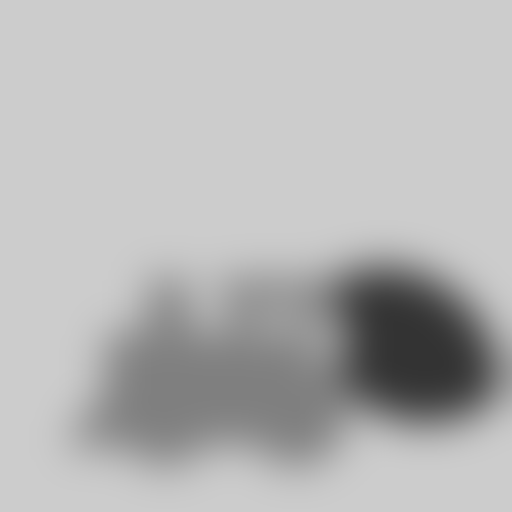

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Token list ['<krk>']
<fda>
Token list ['<krk>']
<xtc>


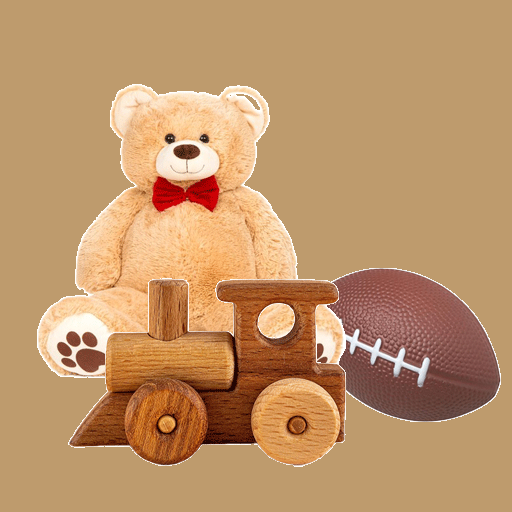

  0%|          | 0/40 [00:00<?, ?it/s]

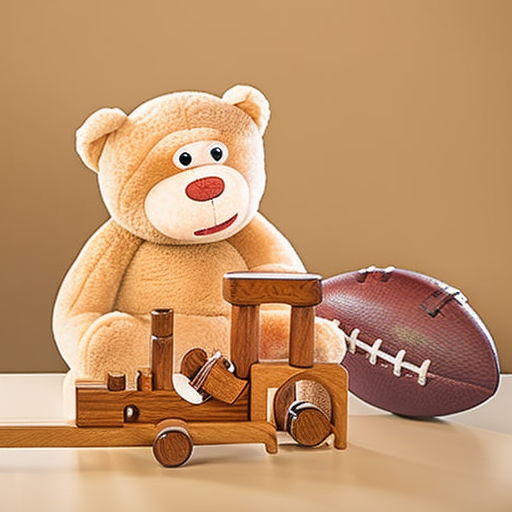

  0%|          | 0/40 [00:00<?, ?it/s]

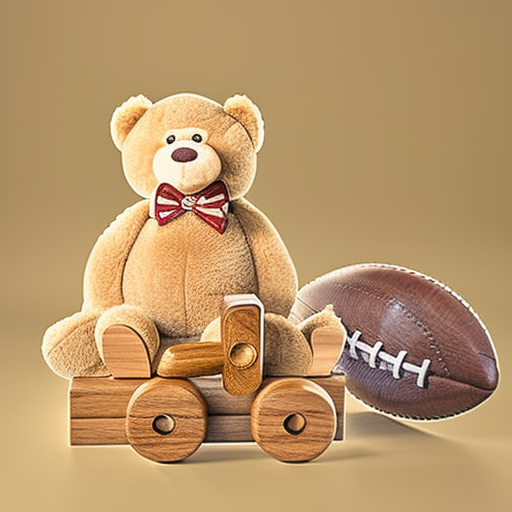

  0%|          | 0/40 [00:00<?, ?it/s]

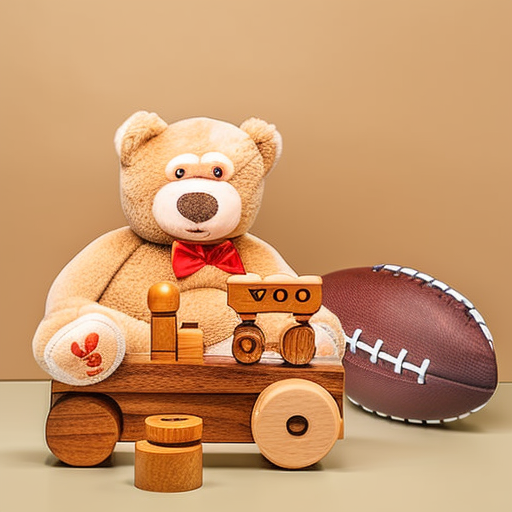

  0%|          | 0/40 [00:00<?, ?it/s]

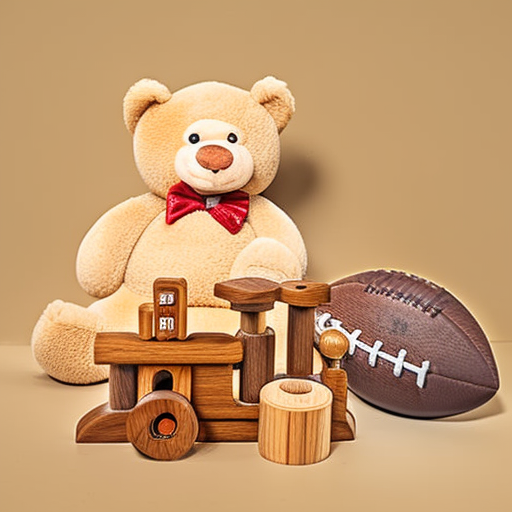

  0%|          | 0/40 [00:00<?, ?it/s]

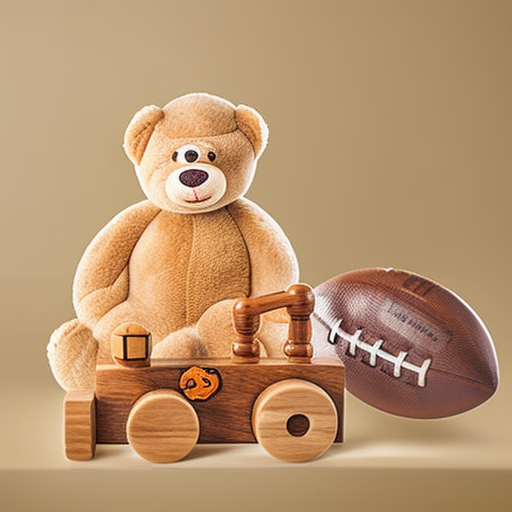

  0%|          | 0/40 [00:00<?, ?it/s]

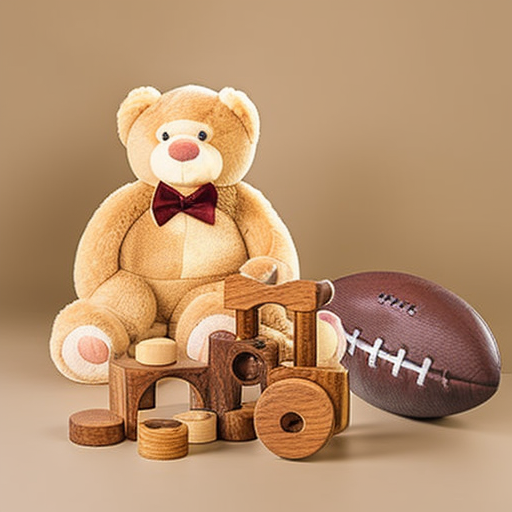

  0%|          | 0/40 [00:00<?, ?it/s]

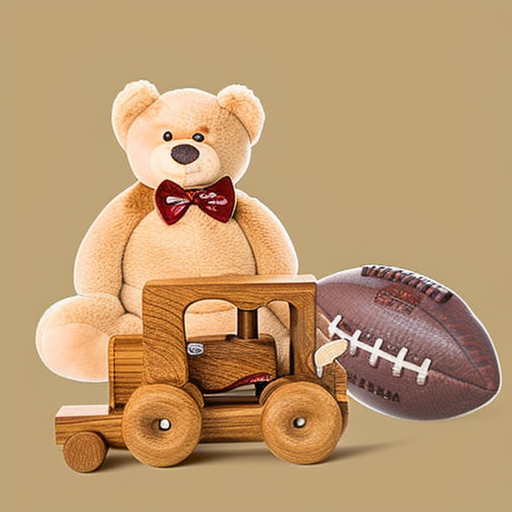

  0%|          | 0/40 [00:00<?, ?it/s]

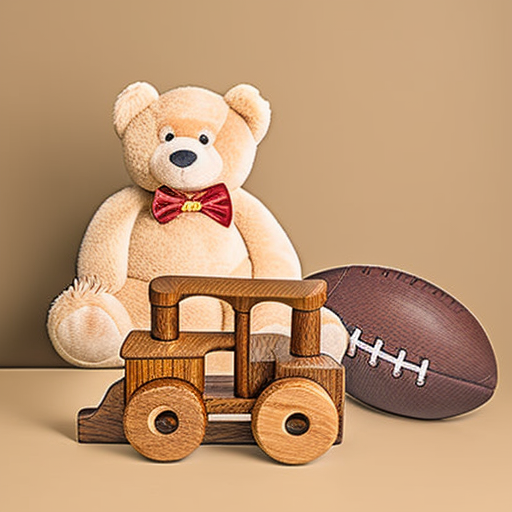

  0%|          | 0/40 [00:00<?, ?it/s]

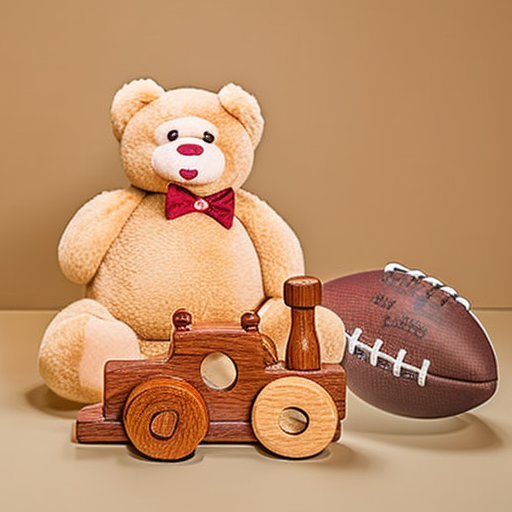

  0%|          | 0/40 [00:00<?, ?it/s]

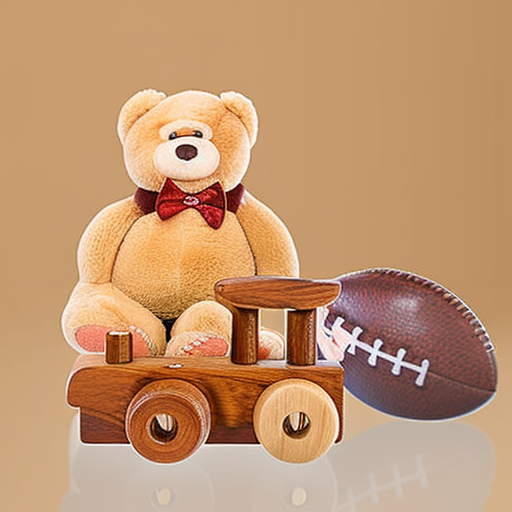

In [17]:
room_images = all_collage("toyBox2_step1", collage_prompt, layer_list, ca=True, textual_inversion=True, inversion_step_list=[1000]*4, device_id=0, 
            input_seed=None, w_pos = [0.0,0.5,0.2,0.2], w_neg = [0.5,0.5,0.5,0.5], img2img_strength=0.8, show_all=True,
                         t_is = [0.8,0.2,0.8,0.5], noise_blur=20, negative_prompt="collage")

## Layer specific editing
What if you like image 3 the best, but would prefer if there was a better train? We create a new collage, where the first layer is the image we are editing, and the second layer re-pastes the content from the original collage for the desired layer to change. The $t_i$ values are set appropriately to allow minimal change in the background layer but a high level of change in the foreground layer. 

In [ ]:
curr_image = room_images[3]
curr_image.putalpha(255)
layer_list_2 = [ImageLayer(curr_image,(0,0),"teddy bear, and an american football, in front of a tan background"),
             layer_list[3]]

In [ ]:
collage_prompt = "a wood train, a teddy bear, and an american football, in front of a tan background"

In [ ]:
room_images_2 = all_collage("toyBox2_step2", collage_prompt, layer_list_2, ca=True, textual_inversion=True, inversion_step_list=[1000]*2, device_id=0, 
            input_seed=None, w_pos = [0.0,0.0], w_neg = [0.2,0.0], img2img_strength=0.8, show_all=True,
                         t_is = [0.05,1.0], noise_blur=50, negative_prompt="collage, warped")

# Bento Box Scene

In [ ]:
layer_list = import_scene("bentoBox")

In [ ]:
collage_prompt = "a bento box with rice, edamame, ginger, and sushi"

Key parameters: "collage prompt" is the overall collage text string, containing text corresponding to each layer. ca=True indicates that we manipulate cross-attention layers, and w_pos and w_neg govern the weights for manipulating cross-attention. textual_inversion=True indicates that we use learned representations per layer, and inversion_step_list indicates the checkpoint step from inversion used for each layer. t_is indicates the noise level $t_i$ added to each layer. 

In [ ]:
room_images = all_collage("bentoBox_step1final", collage_prompt, layer_list, ca=True, textual_inversion=True, inversion_step_list=[1000,500,1000,1000,1000], device_id=0, 
            input_seed=None, w_pos = [0.0,0.4,0.0,0.6,0.2], w_neg = [0.5,0.5,0.5,0.5,0.5], img2img_strength=0.8, show_all=True,
                         t_is=[0.5,0.5,0.6,0.8,0.8], noise_blur=20, negative_prompt="collage")

## Layer specific editing
Everything except the sushi is great in image 5: let's try variants!

In [ ]:
curr_image = room_images[5]
curr_image.putalpha(255)
layer_list_2 = [ImageLayer(curr_image,(0,0),"bento box with rice, edamame, ginger"),
             layer_list[4]]

In [ ]:
collage_prompt = "a bento box with rice, edamame, ginger, and sushi"

We create a new collage, where the first layer is the image we are editing, and the second layer re-pastes the content from the original collage for the desired layer to change. The $t_i$ values are set appropriately to allow minimal change in the background layer but a high level of change in the foreground layer. 

In [ ]:
room_images_2 = all_collage("bentoBox_step2final", collage_prompt, layer_list_2, ca=True, textual_inversion=True, inversion_step_list=[1000]*2, device_id=0, 
            input_seed=None, w_pos = [0.0,0.2], w_neg = [0.2,0.0], img2img_strength=0.8, show_all=True,
                         t_is=[0.05,1.0], noise_blur=30, negative_prompt="collage, warped, ugly")

Now, let's swap the ginger.

In [ ]:
curr_image = room_images_2[2]
curr_image.putalpha(255)
layer_list_3 = [ImageLayer(curr_image,(0,0),"bento box with rice, edamame, sushi"),
             layer_list[3]]

In [ ]:
collage_prompt = "a bento box with rice, edamame, sushi, and ginger"

We create a new collage, where the first layer is the image we are editing, and the second layer re-pastes the content from the original collage for the desired layer to change. The $t_i$ values are set appropriately to allow minimal change in the background layer but a high level of change in the foreground layer. 

In [ ]:
room_images_3 = all_collage("bentoBox_step3final", collage_prompt, layer_list_3, ca=True, textual_inversion=True, inversion_step_list=[1000]*2, device_id=0, 
            input_seed=None, w_pos = [0.0,0.5], w_neg = [0.5,0.0], img2img_strength=0.7, show_all=True,
                         t_is=[0.05,1.0], noise_blur=30, negative_prompt="collage")

# Cake Scene

In [ ]:
layer_list = import_scene("cakeTable2")

In [ ]:
layer_list[4].image_str = "pink cakes"

In [ ]:
collage_prompt = "a wood table with two white chairs behind, two pink cakes on top, maroon bookshelves behind, and winter window"

In [ ]:
room_images = all_collage("cakeTable3_step1final", collage_prompt, layer_list, ca=True, textual_inversion=True, inversion_step_list=[500,1000,1000,1000,100], device_id=0, 
            input_seed=None, w_pos = [0.45,0.35,0.5,0.1,0.3], w_neg = [1.0,1.0,1.0,1.0,2.0], img2img_strength=0.75, show_all=True,
                         t_is=[0.8,0.8,0.8,0.6,0.6], noise_blur=10, negative_prompt="collage, warped, cupcake")

## Layer specific editing
Looks like image 1 turned out pretty nice - let's build on that!

In [ ]:
curr_image = room_images[5]
curr_image.putalpha(255)
layer_list_2 = [ImageLayer(curr_image,(0,0),"wood table with two white chairs behind, maroon bookshelves behind, and winter window"),
             layer_list[4]]

In [ ]:
collage_prompt = "two pink cakes on a wood table with two white chairs behind, maroon bookshelves behind, and winter window "

We create a new collage, where the first layer is the image we are editing, and the second layer re-pastes the content from the original collage for the desired layer to change. The $t_i$ values are set appropriately to allow minimal change in the background layer but a high level of change in the foreground layer. 

In [ ]:
room_images_2 = all_collage("cakeTable3_step2final", collage_prompt, layer_list_2, ca=True, textual_inversion=True, inversion_step_list=[100]*2, device_id=0, 
            input_seed=None, w_pos = [0.0,0.0], w_neg = [0.5,0.0], img2img_strength=0.75, show_all=True,
                         t_is=[0.05,1.0], noise_blur=20, negative_prompt="collage, warped", seed_offset=0)

Now let's swap the window.

In [ ]:
curr_image = room_images_2[6]
_, masks = ImageLayer.add_layers(layer_list)
blurred_mask = np.array(Image.fromarray((masks[0]*255).astype(np.uint8), 'L').filter(ImageFilter.GaussianBlur(10)))/255.
curr_image.putalpha(255)
curr_np = np.array(curr_image)/255.
curr_np[:,:,3] *= (1.0 - (blurred_mask > 0.6))
curr_image = Image.fromarray((curr_np*255).astype(np.uint8), 'RGBA')

In [ ]:
curr_image

In [ ]:
layer_list_3 = [layer_list[0], ImageLayer(curr_image,(0,0),"two pink decorated cakes on a wood table with two white chairs behind, maroon bookshelf behind,")]

In [ ]:
collage_prompt = "two pink decorated cakes on a wood table with two white chairs behind, maroon bookshelf behind, and winter window"

We create a new collage, where the first layer is the image we are editing, and the second layer re-pastes the content from the original collage for the desired layer to change. The $t_i$ values are set appropriately to allow minimal change in the background layer but a high level of change in the foreground layer. 

In [ ]:
room_images_3 = all_collage("cakeTable3_step3final", collage_prompt, layer_list_3, ca=True, textual_inversion=True, inversion_step_list=[500,500], device_id=0, 
            input_seed=None, w_pos = [0.4,0.0], w_neg = [0.0,0.0], img2img_strength=0.75, show_all=True,
                         t_is=[1.0,0.05], noise_blur=10, negative_prompt="collage, warped", seed_offset=10)